In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('MovieRankingData2024.csv')
A = df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce').to_numpy()
print(A)

[[4.5 4.  4.5 ... 4.4 4.  2.9]
 [5.  4.  4.  ... 5.  3.  3. ]
 [4.  3.9 4.3 ... 4.4 3.6 3.1]
 ...
 [3.5 3.  4.5 ... 4.  2.  3. ]
 [3.  3.  4.  ... 4.  5.  2. ]
 [nan 3.  nan ... nan nan nan]]


### 1. (a) Low-Rank Factorization

In [3]:
def completion_alternating(A, l, k, iters):
  n, d = A.shape
  X = np.random.rand(n, k)
  Y = np.random.rand(d, k)

  for _ in range(iters):
    for i in range(n):
      omega_i = ~np.isnan(A[i, :])
      Y_omega_i = Y[omega_i, :]
      a_omega_i = A[i, omega_i]

      M = Y_omega_i.T @ Y_omega_i + l * np.identity(Y_omega_i.shape[1])
      b = Y_omega_i.T @ a_omega_i
      x_i = np.linalg.solve(M, b)
      X[i, :] = x_i

    for j in range(d):
      omega_j = ~np.isnan(A[:, j])
      X_omega_j = X[omega_j, :]
      a_omega_j = A[omega_j, j]

      M = X_omega_j.T @ X_omega_j + l * np.identity(X_omega_j.shape[1])
      b = X_omega_j.T @ a_omega_j
      y_j = np.linalg.solve(M, b)
      Y[j, :] = y_j

  return X, Y

In [4]:
X, Y = completion_alternating(A, 0.1, 7, 100)
M = X @ Y.T
print(np.linalg.norm((A - M)[~np.isnan(A)]))

13.894367449157455


### 1. (b) Penalizing Nuclear Norm

In [5]:
def completion_nuclear(A, l, iters):
  n, d = A.shape
  M = np.random.rand(n, d)
  for _ in range(iters):
    P_omega = A - M
    P_omega[np.isnan(P_omega)] = 0

    U, S, V = np.linalg.svd(M + P_omega, full_matrices=False)
    S = np.maximum(S - l * np.ones(S.shape[0]), 0)
    M = U @ np.diag(S) @ V
  return M

In [6]:
lambdas = [1e-4, 1e-3, 1e-2, 1e-1, 1]
for l in lambdas:
  M = completion_nuclear(A, l, 10)
  print(np.linalg.norm((A - M)[~np.isnan(A)]))

0.00037185682308053537
0.003713573183544024
0.037108700105282
0.37333904233925574
3.94258590031348


### 2. Nuclear Norm Promoting Low Rank

In [7]:
def nuclear_norm(x, y, z):
  A = np.array([[0.5, x], [y, z]])
  S = np.linalg.svd(A, compute_uv=False)
  return np.sum(S)

def det(w, x, y, z):
  return w * z - x * y

In [8]:
def plot_curves(z, a):
  xs = np.linspace(-1, 1, 100)
  ys = np.linspace(-1, 1, 100)
  X, Y = np.meshgrid(xs, ys)

  # Zero level set of det(A)
  dets = np.vectorize(det)(0.5, X, Y, z)
  plt.contour(X, Y, dets, levels=[0], colors='r')

  # Level set for nuclear norm equal to 1
  norms = np.vectorize(nuclear_norm)(X, Y, z)
  plt.contour(X, Y, norms, levels=[a], colors='b')

  plt.title(f'Curves for z={z}')
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.show()

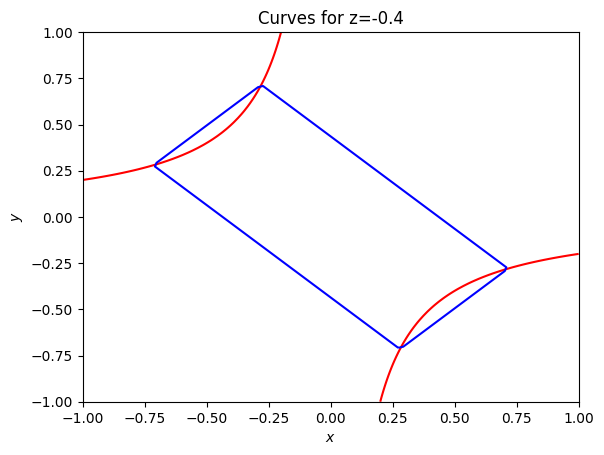

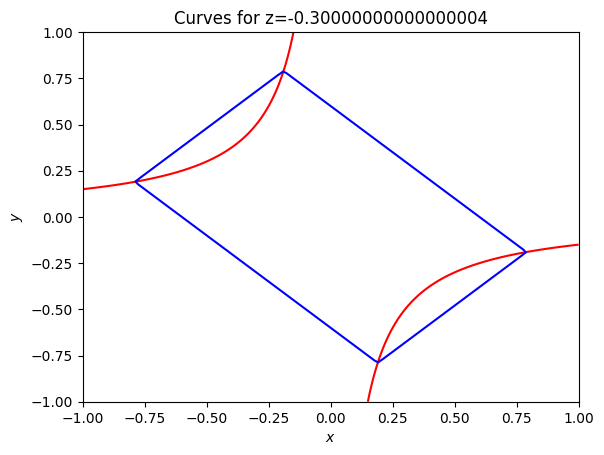

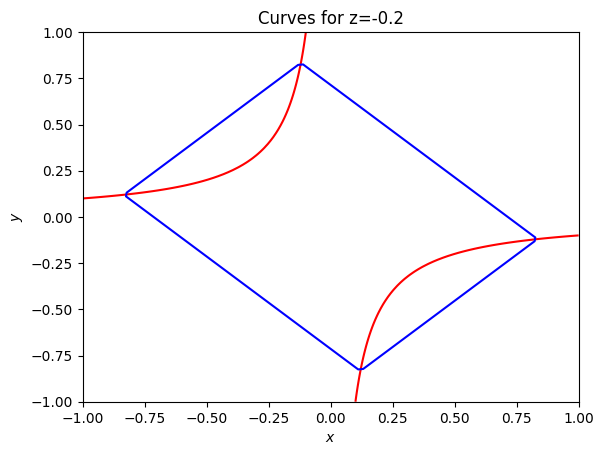

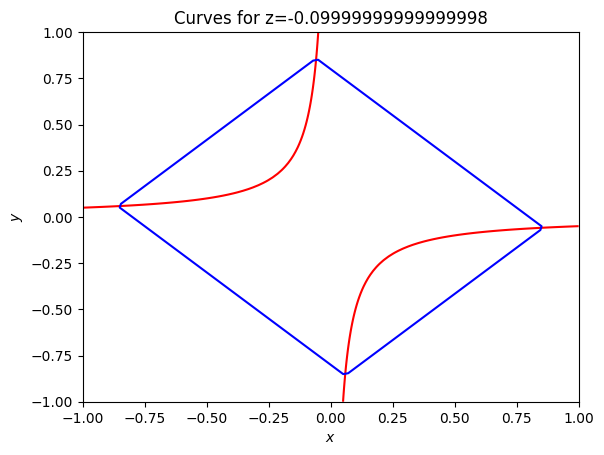

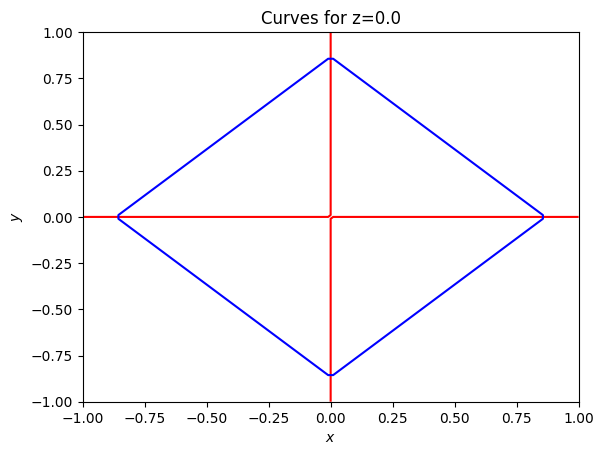

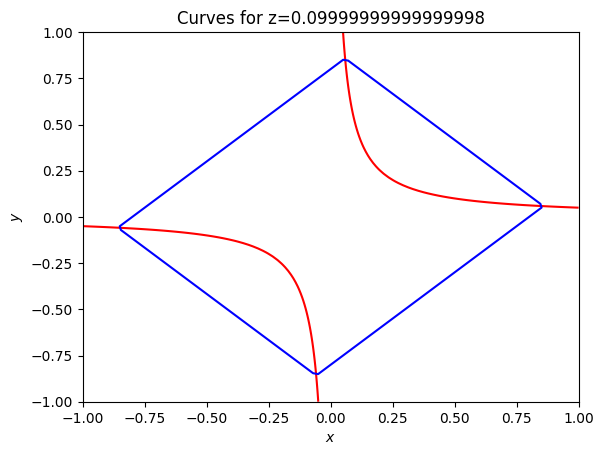

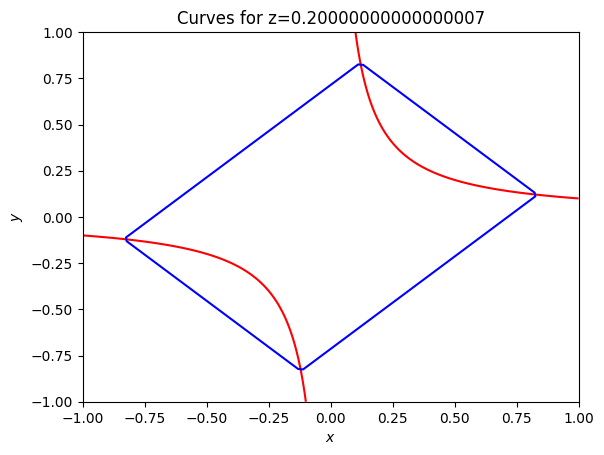

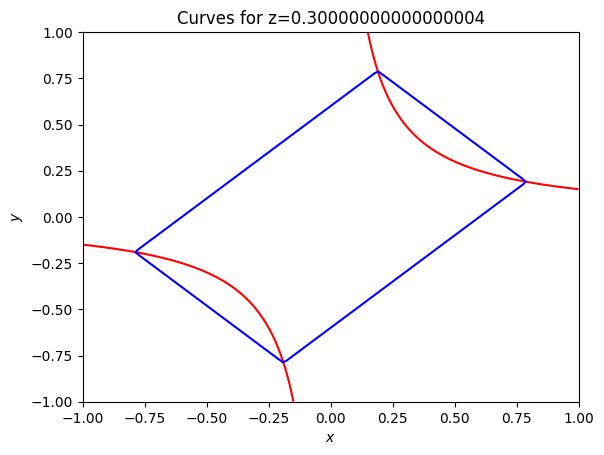

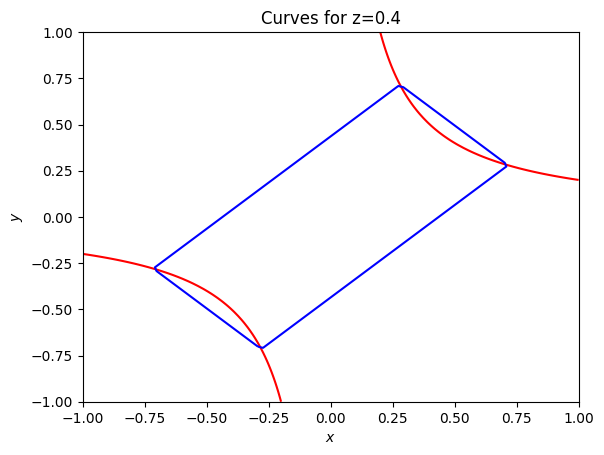

In [9]:
zs = np.linspace(-0.4, 0.4, 9)

for z in zs:
  plot_curves(z, 1)